In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
from PIL import Image
import os

<font size="5"><font color="DarkPurple">
 --Before we upload the data we have to refine the images into the labels given in the CSV file  by parsing both through a script.<BR> 
 --Loading the train data, First half of the image contains the images and the second half contains the respective segmentation required to train our segmentation model.
 --The model loads its respective classes from the directory.(Healthy / diseased)</font>

In [3]:
train_dir='E:\IISC academics\SEM- 2\DS-216 Machine learning for data science\Assignments\Assignment 2\ASSN2_Q2\classified'
train_images=[]
train_segmentations=[]
train_labels=[]
for class_name in os.listdir(train_dir):
    class_dir=os.path.join(train_dir,class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        img_path=os.path.join(class_dir,img_file)
        concat_img=Image.open(img_path)
        concat_img=np.array(concat_img)
        img=concat_img[:,:256]       #load the first half of the image.
        seg=concat_img[:,256:]       #load the second half of the image as mask / segmentatiion label to train our segmentation model
        train_images.append(img)
        train_segmentations.append(seg)
        train_labels.append(class_name)
train_images=np.array(train_images)
train_segmentations=np.array(train_segmentations)
train_labels=np.array(train_labels)

In [4]:
variance_channel_4=np.var(train_images[:,:,:,3]) #check the variance in the 4th channel to see if it contains any useful information
variance_channel_4

0.0

In [5]:
train_images=train_images[:,:,:,:3]               #remove the 4th channel of the images
train_segmentations=train_segmentations[:,:,:,:1] #reduce the masks to 1 channel as it is binary masks
train_segmentations.shape

(919, 256, 256, 1)

In [6]:
label_counts={label:np.sum(train_labels==label) for label in np.unique(train_labels)}
label_counts
#we can observe that there is class imbalance.

{'Healthy': 496, 'diseased': 423}

First 10 labels: ['diseased' 'diseased' 'diseased' 'diseased' 'diseased' 'diseased'
 'diseased' 'diseased' 'diseased' 'diseased']
Label:diseased


Label:diseased


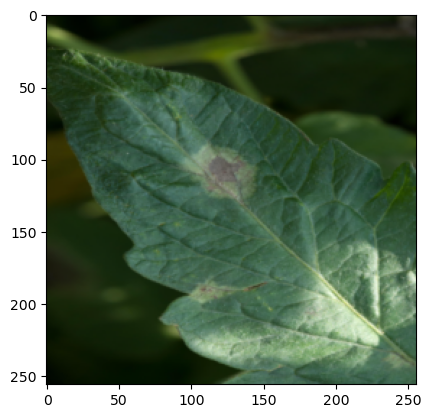

Label:diseased


Label:diseased


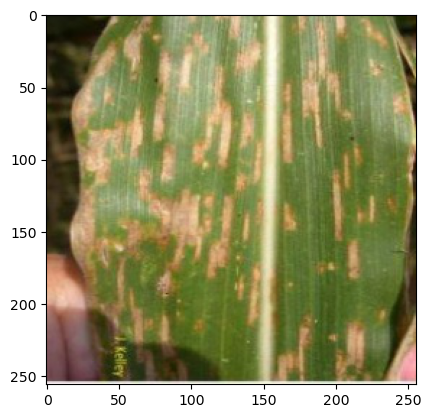

Label:diseased


Label:diseased


Label:diseased


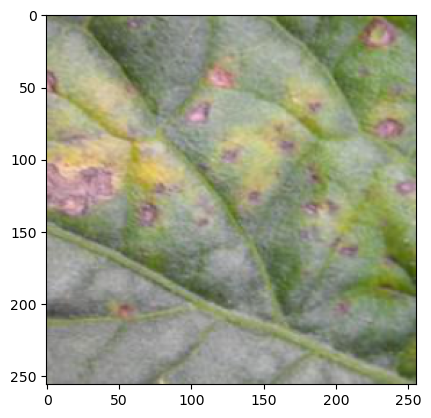

Label:diseased


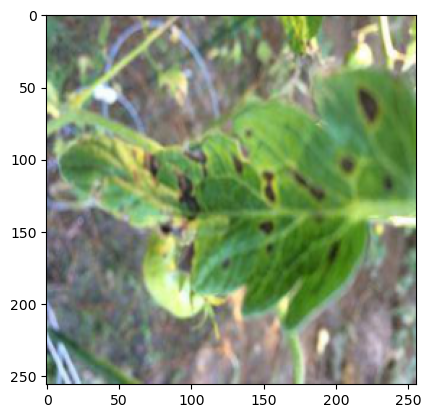

Label:diseased


Label:diseased


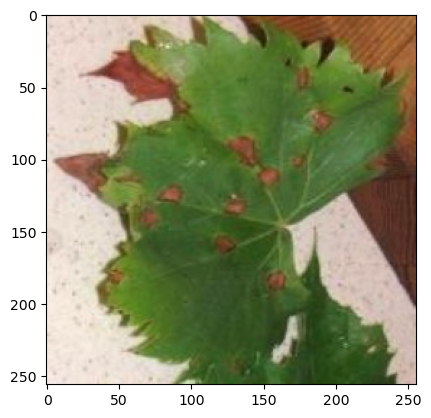

In [7]:
print("First 10 labels:",train_labels[:10])
for i in range(10):
    print(f"Label:{train_labels[i]}")
    plt.imshow(train_images[i])
    plt.show()

<font size="5"><font color="DarkPurple">
 Now that we have checked that the images and labels are correctly matched.</font>

In [8]:
image_index=0
image_tensor=train_images[image_index]
print("Shape of image tensor:",image_tensor.shape)
for channel in range(image_tensor.shape[2]):
    channel_values=image_tensor[:,:,channel]
    top_10_values=np.sort(channel_values.flatten())[::-1][:10]
    print(f"Top 10 values for Channel {channel+1}:",top_10_values)

Shape of image tensor: (256, 256, 3)
Top 10 values for Channel 1: [251 250 250 250 249 249 248 247 247 247]
Top 10 values for Channel 2: [254 254 252 252 252 252 252 251 250 250]
Top 10 values for Channel 3: [255 254 252 251 250 249 249 242 240 239]


In [65]:
def normalize_images(images):
    images = images.astype('float32')  #Lets normalize the images so that the values are within 0-1 
    images /= 255.0  # As images wont have negetive values we do not perform mean centering
    return images
Ntrain_img=normalize_images(train_images)
Ntrain_seg=normalize_images(train_segmentations)
print("Ntrain shape:",Ntrain_img.shape,"datatype:",Ntrain_img.dtype)

Ntrain shape: (919, 256, 256, 3) datatype: float32


In [10]:
print("train_images:",np.shape(Ntrain_img))
print("train_segmentations:",np.shape(Ntrain_seg))
len(np.unique(train_labels)) #recheck the shape of the normalised images

train_images: (919, 256, 256, 3)
train_segmentations: (919, 256, 256, 1)


2

First 10 labels: [1 1 1 1 1 1 1 1 1 1]
Label: 1


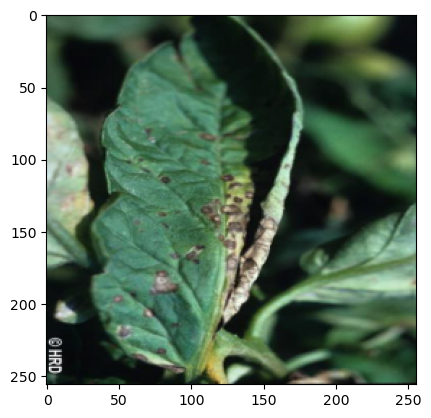

Label: 1


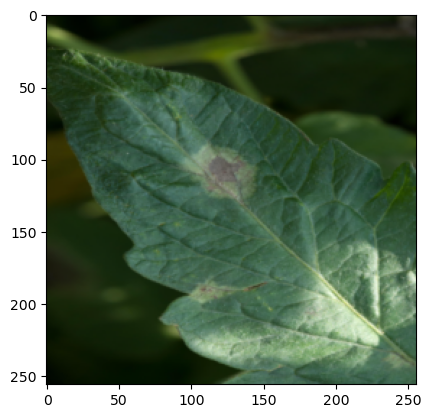

Label: 1


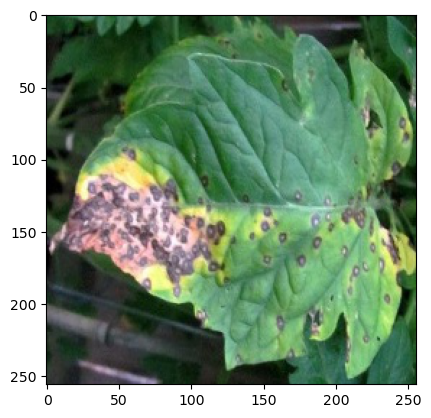

Label: 1


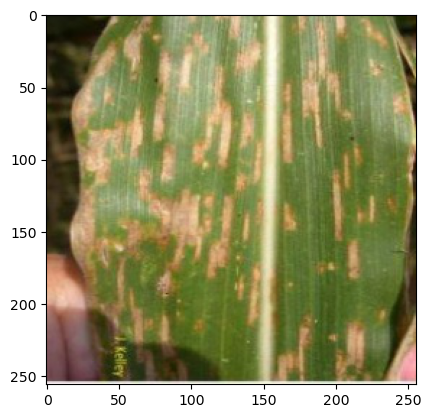

Label: 1


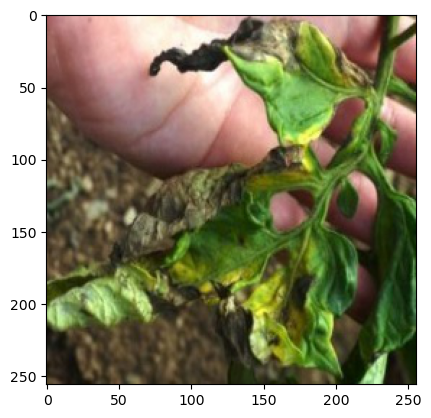

Label: 1


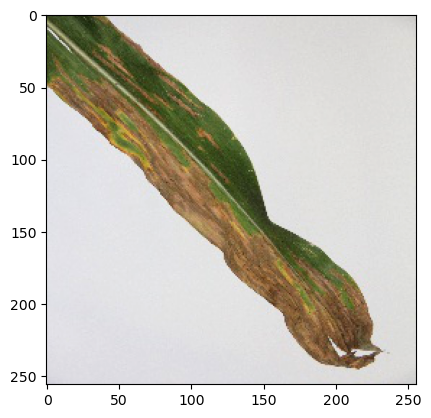

Label: 1


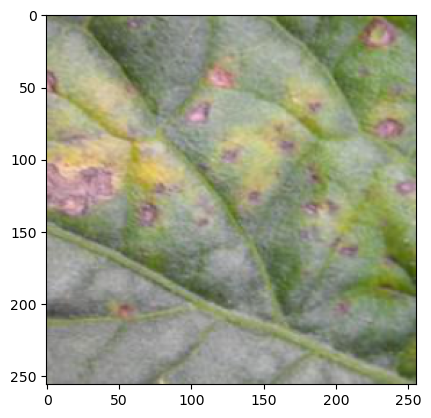

Label: 1


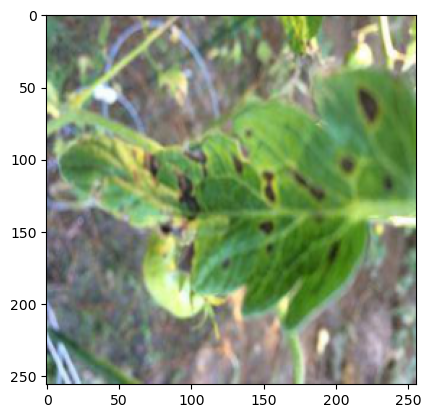

Label: 1


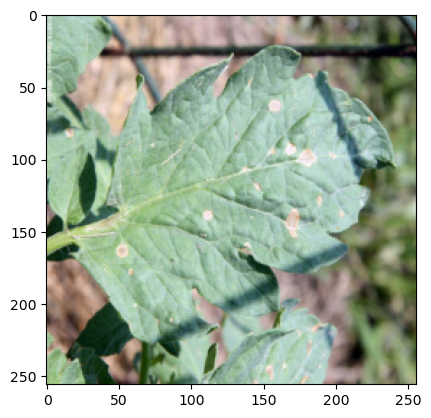

Label: 1


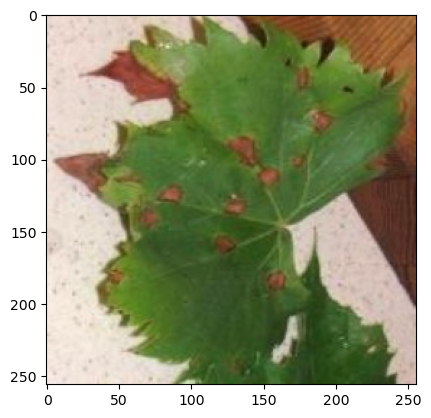

In [11]:
binary_labels = np.where(train_labels == 'Healthy', 0, 1)  #convert the classes to binary class
print("First 10 labels:",binary_labels[:10])
for i in range(10):
    print(f"Label: {binary_labels[i]}")
    plt.imshow(train_images[i])
    plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(Ntrain_img,binary_labels,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=42)
#perform train test split for hyperparameter runing and training the model

<font size="5"><font color="DarkPurple">
 --Train test split - Split the data to 80%  training and 20% testing<BR>
 -- For the training process lets further split our train data to again validation data which will be 20% of our original dataset</font>

In [13]:
#lets check the shape and datatype for training our model/
print("X_train shape:",X_train.shape,"datatype:",X_train.dtype)
print("y_train shape:",y_train.shape,"datatype:",y_train.dtype)
print("X_val shape:",X_val.shape,"datatype:",X_val.dtype)
print("y_val shape:",y_val.shape,"datatype:",y_val.dtype)
print("X_test shape:",X_test.shape,"datatype:",X_test.dtype)
print("y_test shape:",y_test.shape,"datatype:",y_test.dtype)

X_train shape: (551, 256, 256, 3) datatype: float32
y_train shape: (551,) datatype: int32
X_val shape: (184, 256, 256, 3) datatype: float32
y_val shape: (184,) datatype: int32
X_test shape: (184, 256, 256, 3) datatype: float32
y_test shape: (184,) datatype: int32


<font size="5"><font color="DarkPurple">
 -- Based on the knowledge by observing the dataset,the model should be able to pcapture complex featuures and because of which a deep model can perform well <BR> --And as the amount of data available for training is less I chose to perform transfer learning using pretrained model as a backbone and replace the fully connected networks<BR>
    --After comparing different models on https://keras.io/api/applications/ i noticed that on an average efficientnets were more accuurate and lighter than the rest. <BR>
    --With the further requirement to perform segmentation by extracting features from intermediate layers to boost our segmentation task i realised it would be hard to inference from resnet and especially deep resnets.
</font>

In [14]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.optim import Adam
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision import transforms

<font size="5"><font color="DarkPurple">
**--Choice of Model**   - https://paperswithcode.com/method/efficientnet EfficientNet architectures incorporate advanced design principles such as depthwise separable convolutions, squeeze-and-excitation blocks, and inverted residual blocks. These components enhance the model's ability to extract informative features from input images, leading to better representation learning and discriminative power. this makes it ideal for our dataset.<BR>
   ---After a few trials realised the fully connected layers were too simple to capture the complex features. So added more layers and introduce dropout.o avoid overfitting in the final layers</font>

In [16]:
X_train_hyper, X_val_hyper, y_train_hyper, y_val_hyper = train_test_split(X_val,y_val,test_size=0.25,random_state=42)
X_train_hyper=torch.from_numpy(X_train_hyper).permute(0,3,1,2).to(device)
y_train_hyper=torch.from_numpy(y_train_hyper).unsqueeze(1).float().to(device)
X_val_hyper=torch.from_numpy(X_val_hyper).permute(0,3,1,2).to(device)
y_val_hyper=torch.from_numpy(y_val_hyper).unsqueeze(1).float().to(device)

<font size="5"><font color="DarkPurple">
--Converting the data to PyTorch tensors and moving them to the specified device  GPU) for efficient computation<br>--Permuting the dimensions of the images to match the expected input format for PyTorch models (batch_size, channels, height, width<br>
--Converting the labels to float and unsqueezing to match the shape required for loss calculation in PyTorch.</font>

In [17]:
hyperparameters=[
    {'lr':0.001,'batch_size':30,'epochs':40},
    {'lr':0.0005,'batch_size':50,'epochs':40},
    {'lr':0.0005,'batch_size':30,'epochs':40},
    {'lr':0.001,'batch_size':32,'epochs':40},
    {'lr':0.0005,'batch_size':60,'epochs':40},
    {'lr':0.01,'batch_size':30,'epochs':40},
    {'lr':0.05,'batch_size':30,'epochs':40},
    {'lr':0.01,'batch_size':30,'epochs':40},
    {'lr':0.1,'batch_size':30,'epochs':40}]
train_data_hyper=torch.utils.data.TensorDataset(X_train_hyper,y_train_hyper)
val_data_hyper=torch.utils.data.TensorDataset(X_val_hyper,y_val_hyper)
results=[]
# defining a sdet of hyperparameters to perform hyperparameter tuning

In [ ]:
pip install efficientnet_pytorch

<font size="5"><font color="DarkPurple">
Defining a set of hyperparameters to perform hyperparameter tuning
# Created a list of dictionaries called 'hyperparameters' where each dictionary contains different combinations of learning rates, batch sizes, and epochs.
# These hyperparameters will be used to train the model with different settings to find the optimal combination.<font size="5">


In [17]:
def create_efficientnet_model():
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained('efficientnet-b2')  #load pretrained weights but add fully connected networks for bianry classification
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 1),
        nn.Sigmoid())    
    model.to(device)
    return model

<font size="5"><font color="DarkPurple">
--Using pretrained Efficientnet-b2 we load the weights which are trained on COCO dataset in pytorch<BR>
--We replace the final fully connected layers to perform binary class classification as required as efficient net is trained for multiclass classification<BR> 
--This helps us retain our hierarchical feature learning that has already been learnt by the model as we have a small dataset to train from scratch</font>

In [19]:
!pip install torchsummary

In [18]:
from torchsummary import summary
classification_model= create_efficientnet_model()
summary(classification_model, input_size=(3, 256, 256))

Loaded pretrained weights for efficientnet-b2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [-1, 32, 128, 128]             864
       BatchNorm2d-3         [-1, 32, 128, 128]              64
MemoryEfficientSwish-4         [-1, 32, 128, 128]               0
         ZeroPad2d-5         [-1, 32, 130, 130]               0
Conv2dStaticSamePadding-6         [-1, 32, 128, 128]             288
       BatchNorm2d-7         [-1, 32, 128, 128]              64
MemoryEfficientSwish-8         [-1, 32, 128, 128]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13        

<font size="5"><font color="DarkPurple">
--We can make the fully connected layers more complex to capture complex features but increase our dropout rate to avoid overfitting<BR>
--We also need to introduce batch normalisation before each layers.<BR>
-- Use RELU activation function in the initial layers which introduces non-linearity,but in the final layers we use Sigmoid activation to perform binary classification as required<BR>
-- We use dropout as a regularizer</font>

In [20]:
def create_efficientnet_model():
    from efficientnet_pytorch import EfficientNet
    classification_model=EfficientNet.from_pretrained('efficientnet-b2')  #load pretrained weights but add fully connected networks for bianry classification
    for param in classification_model.parameters():
        param.requires_grad=False
    num_ftrs=classification_model._fc.in_features
    classification_model._fc=nn.Sequential(
        nn.Linear(num_ftrs,1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.7), #as there are possibilities to overfit the dataset in the dense layer as we have used multiple dense layers.
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.7),
        nn.Linear(512,1),
        nn.Sigmoid())
    classification_model.to(device)
    return classification_model

Loaded pretrained weights for efficientnet-b2


Loaded pretrained weights for efficientnet-b2


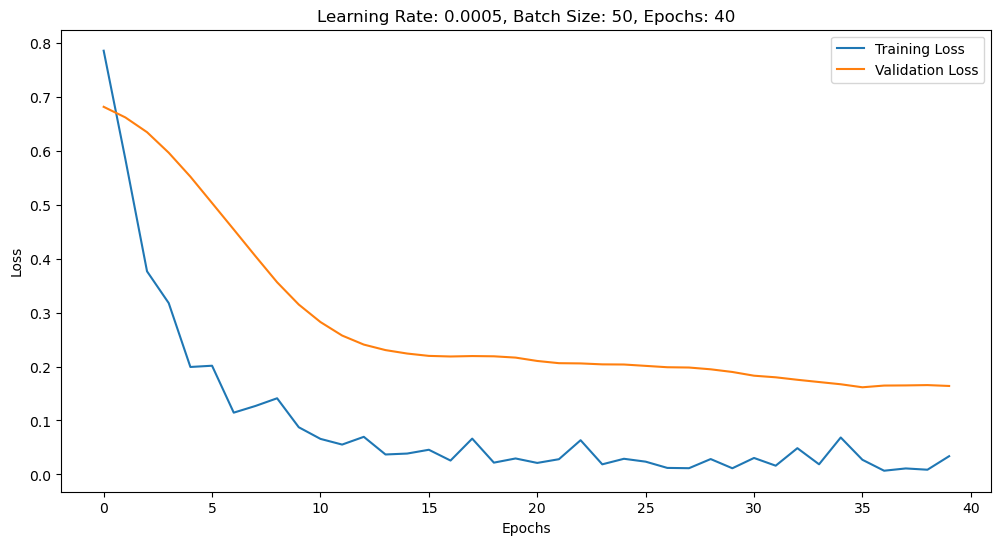

Loaded pretrained weights for efficientnet-b2


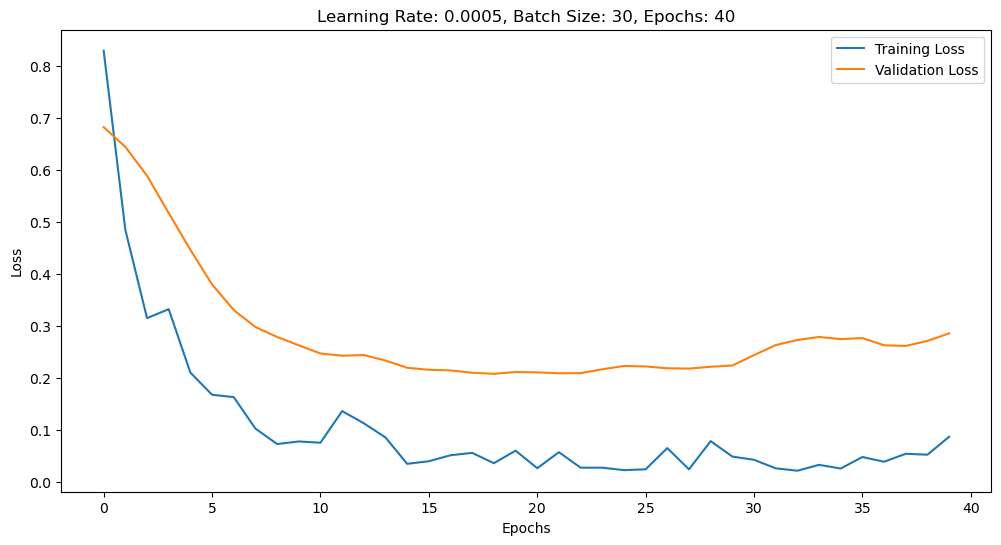

Loaded pretrained weights for efficientnet-b2


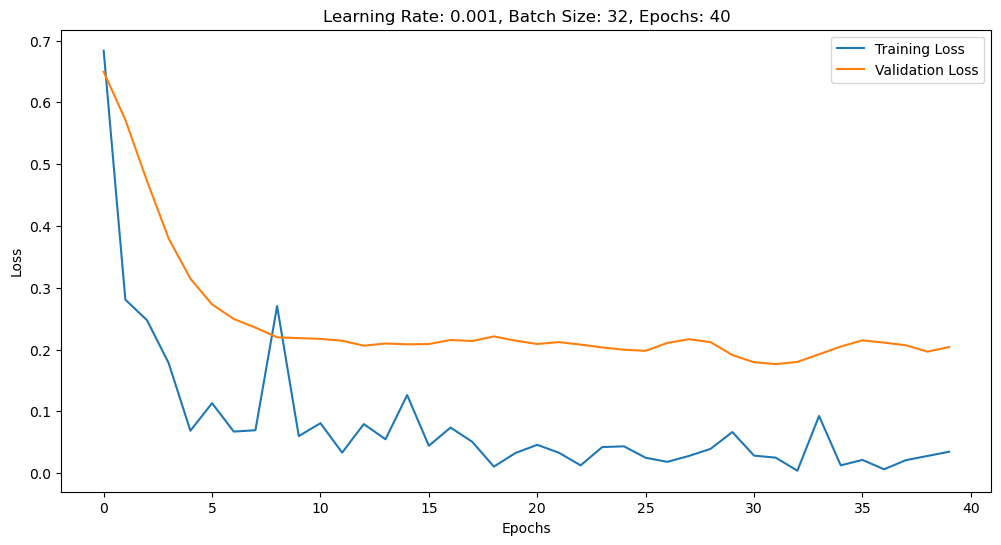

Loaded pretrained weights for efficientnet-b2


Loaded pretrained weights for efficientnet-b2


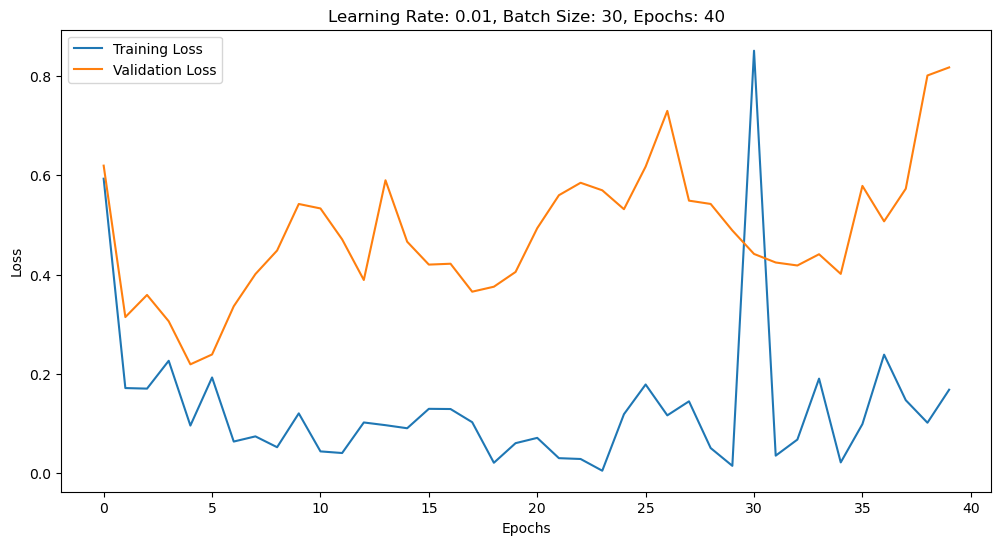

Loaded pretrained weights for efficientnet-b2


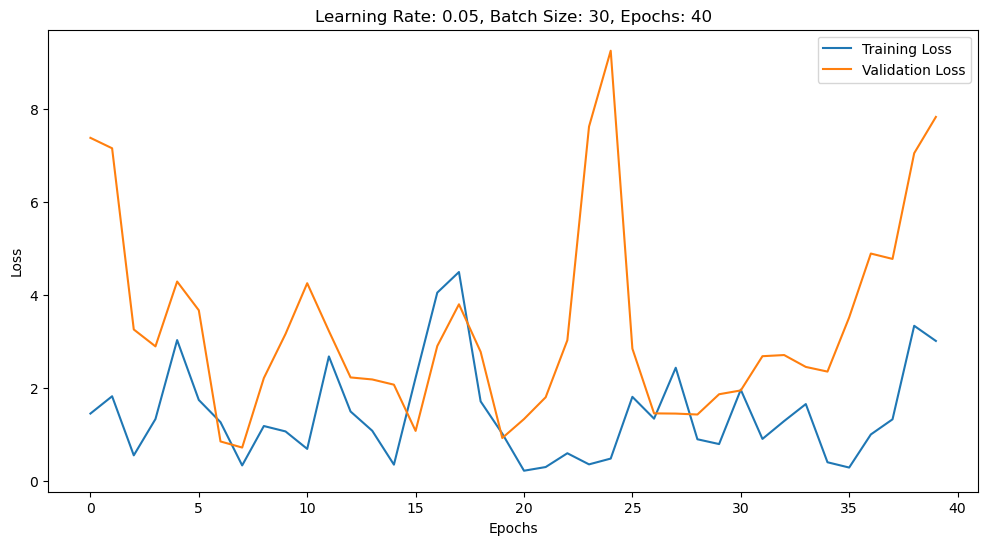

Loaded pretrained weights for efficientnet-b2


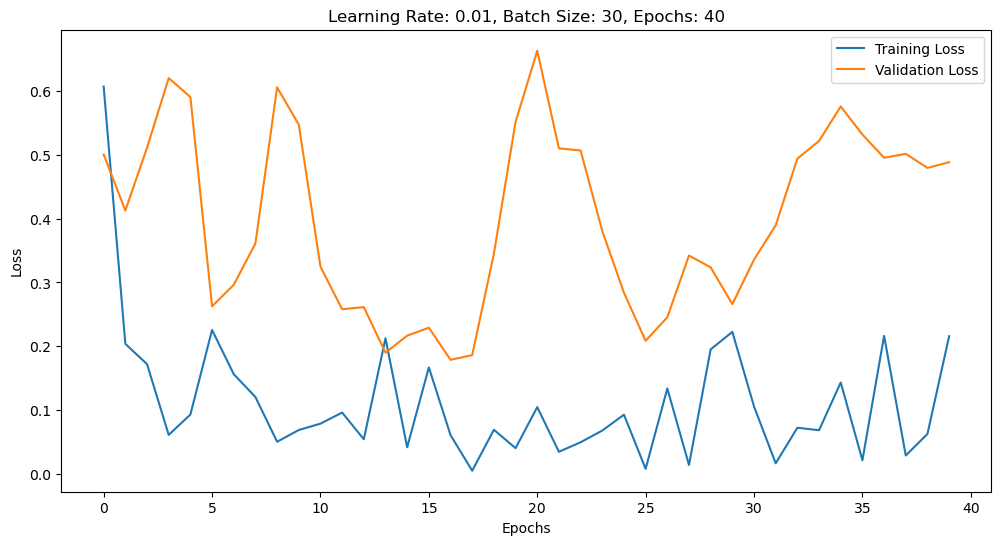

Loaded pretrained weights for efficientnet-b2


In [22]:
for params in hyperparameters:
    classification_model = create_efficientnet_model()  #each loop we have to re-define our model weights 
    classification_model.to(device)    #move the model to gpu
    criterion = nn.BCELoss()   #use binary cross entropy as it is a binary classification task 
    optimizer = Adam(classification_model.parameters(), lr=params['lr'])  
    train_loader = DataLoader(train_data_hyper, batch_size=params['batch_size'], shuffle=True) 
    val_loader = DataLoader(val_data_hyper, batch_size=params['batch_size']) 
    train_losses = []
    val_losses = []
    for epoch in range(params['epochs']):
        classification_model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classification_model(inputs)  
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        classification_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = classification_model(inputs)  
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
    results.append((params, val_losses[-1]))
    #we should plot the graph to understand how the model is converging  -- overfitting or underfitting etc..
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Learning Rate: {params['lr']}, Batch Size: {params['batch_size']}, Epochs: {params['epochs']}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [23]:
best_hyperparams = min(results, key=lambda x: x[1])
print(f'Best Hyperparameters: {best_hyperparams[0]}')

Best Hyperparameters: {'lr': 0.0005, 'batch_size': 50, 'epochs': 40}


<font size="5"><font color="DarkPurple">We notice overfitting of the model.<BR>
And we can increase the number of epochs as we see the model is still converging. So i decided to implement a learning rate scheduler as discussed in class and start with higher learning rate but as model progresses we can reduce it.
</font>

<font size="5"><font color="orange">Now to avoid overfitting lets implement techniques such as-<BR>
1. Data augmentation -  gives spatial invariance to the model and gives more generalisation to the model.
2. Learning rate scheduler
3. And momentum based optimizer for gradient update- Adam optimizer.
</font>

In [22]:
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, f1_score

<font size="5"><font color="DarkPurple">We perform data augmentation to generate more data to train our model on and also generate spacial invariance in the model, which will help us generalize the model wrt the orientation, size and scale of the images from our final dataset.<BR>
So here for each image, we are generating 9 augmented images and 1 original image being retained so we have 10x our original data. 
</font>

In [23]:
data_transforms=transforms.Compose([
    Lambda(lambda x:Image.fromarray((x*255).astype(np.uint8))), #as our model efficientnet expects (and performs better when values are ranging bw 0-255
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()])
# we have introduced random flip,rotation and cropping each images will be resized to 244x244x3 as expected by our segmentation model

def augment_data(images,labels,num_augmentations=9):
    augmented_images=[]
    augmented_labels=[]
    for i in range(len(images)):
        original_image=images[i]
        augmented_images.append(data_transforms(original_image))
        for _ in range(num_augmentations):
            augmented_images.append(data_transforms(original_image))
        augmented_labels.extend([labels[i]]*(num_augmentations+1))
    return torch.stack(augmented_images),torch.tensor(augmented_labels,dtype=torch.float32).unsqueeze(1)

In [24]:
X_train_augmented,y_train_augmented=augment_data(X_train,y_train)
X_val_augmented,y_val_augmented=augment_data(X_val,y_val)
X_test_augmented,y_test_augmented=augment_data(X_test,y_test)
train_data=TensorDataset(X_train_augmented,y_train_augmented)
val_data=TensorDataset(X_val_augmented,y_val_augmented)
test_data=TensorDataset(X_test_augmented,y_test_augmented)
print("X_train augmented shape:",X_train_augmented.shape,"datatype:",X_train_augmented.dtype)
print("y_train augmented shape:",y_train_augmented.shape,"datatype:",y_train_augmented.dtype)
print("X_val_augmented shape:",X_val_augmented.shape,"datatype:",X_val_augmented.dtype)
print("y_val_augmented shape:",y_val_augmented.shape,"datatype:",y_val_augmented.dtype)
print("X_test_augmented shape:",X_test_augmented.shape,"datatype:",X_test_augmented.dtype)
print("y_test_augmented shape:",y_test_augmented.shape,"datatype:",y_test_augmented.dtype)

X_train augmented shape: torch.Size([5510, 3, 224, 224]) datatype: torch.float32
y_train augmented shape: torch.Size([5510, 1]) datatype: torch.float32
X_val_augmented shape: torch.Size([1840, 3, 224, 224]) datatype: torch.float32
y_val_augmented shape: torch.Size([1840, 1]) datatype: torch.float32
X_test_augmented shape: torch.Size([1840, 3, 224, 224]) datatype: torch.float32
y_test_augmented shape: torch.Size([1840, 1]) datatype: torch.float32


<font size="5"><font color="orange">We're making sure our labels are in the right format for doing calculations. We're turning them into floating-point numbers and arranging them in a shape that our model can understand.
Now that our data is all set and ready, we're lopading into datasets.<font>

In [25]:
params={'lr':0.001,'batch_size':60,'epochs':60}
classification_model=create_efficientnet_model()
classification_model.to(device)
criterion=nn.BCELoss() #use binary cross entropy loss as it is  a binary classification tasK
optimizer=Adam(classification_model.parameters(),lr=params['lr'],weight_decay=0.01)  #weight decay in adam optimier is to introduce l2 regularising term
scheduler=StepLR(optimizer,step_size=10,gamma=0.1)  #so we reduce our learning rate by 0.1 times every 10 epoch
train_loader=DataLoader(train_data,batch_size=params['batch_size'],shuffle=True)  #training in batches to avoid memory overflow and regularisation
val_loader=DataLoader(val_data,batch_size=params['batch_size'])
test_loader=DataLoader(test_data,batch_size=params['batch_size'])
best_val_loss=float('inf')

Loaded pretrained weights for efficientnet-b2


<font size="5"><font color="DarkPurple">lets add early stopping as his helps us keep track of how well our model is learning. If it stops improving after a certain number of tries (patience), we'll stop training to avoid wasting time.setting the patience to 10 and allowing our model to try 2 times before stopping.<br>
Scheduler helps our model adjust its learning rate during training. It's like giving our model a little guidance on how fast it should be learning.Choosing a small learning rate because it helps our model learn slowly and steadily without making big jumps.We're getting our data ready to feed into the model.organizing it into batches and shuffling it so our model gets random examples to learn from.<be>
--We use higher learning rate and introduce learning rate scheduler which decays the higher learning rate so we do achieve higher convergence in the beginning and as we are using adam (moment based gradient) we are avoiding local minimas<font >


In [26]:
patience=6
trials=0
best_val_loss=float('inf')  # Initialize with positive infinity
for epoch in range(params['epochs']):
    classification_model.train()
    train_loss=0.0    
    train_preds,train_targets=[],[]    
    for inputs,labels in train_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=classification_model(inputs)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())    
    train_acc=accuracy_score(train_targets,np.round(train_preds))
    train_f1=f1_score(train_targets,np.round(train_preds))
    print(f"Epoch {epoch+1}/{params['epochs']}, Train Loss: {train_loss/len(train_loader)}, Train Acc: {train_acc}, Train F1: {train_f1}")    
    classification_model.eval()
    val_loss=0.0
    val_preds,val_targets=[],[]
    
    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=classification_model(inputs)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            val_preds.extend(outputs.detach().cpu().numpy())
            val_targets.extend(labels.detach().cpu().numpy())    
    val_acc=accuracy_score(val_targets,np.round(val_preds))
    val_f1=f1_score(val_targets,np.round(val_preds))
    print(f"Epoch {epoch+1}/{params['epochs']},Validation Loss: {val_loss/len(val_loader)}, Val Acc: {val_acc}, Val F1: {val_f1}")       
    if val_loss<best_val_loss:
        trials=0
        best_val_loss=val_loss
        torch.save(classification_model.state_dict(),'best_model12.pth')
        print("Model saved successfully.")
    else:
        trials+=1
        print(f"Validation loss did not improve.Trials: {trials}/{patience}")
        if trials>=patience:
            print(f'Early stopping on epoch {epoch}')
            break    
    scheduler.step()

Epoch 1/60, Train Loss: 0.2988367837894222, Train Acc: 0.8747731397459165, Train F1: 0.860774818401937
Epoch 1/60,Validation Loss: 0.40124473216072204, Val Acc: 0.8206521739130435, Val F1: 0.8028673835125447
Model saved successfully.
Epoch 2/60, Train Loss: 0.19475765736854594, Train Acc: 0.9219600725952813, Train F1: 0.9117043121149898
Epoch 2/60,Validation Loss: 0.37445222610427487, Val Acc: 0.8516304347826087, Val F1: 0.856993190151912
Model saved successfully.
Epoch 3/60, Train Loss: 0.1861988435215924, Train Acc: 0.926497277676951, Train F1: 0.9167180752621839
Epoch 3/60,Validation Loss: 0.24431385989150695, Val Acc: 0.9016304347826087, Val F1: 0.9015769439912997
Model saved successfully.
Epoch 4/60, Train Loss: 0.18833519890904427, Train Acc: 0.9261343012704174, Train F1: 0.9165470576173878
Epoch 4/60,Validation Loss: 0.2297088537485369, Val Acc: 0.9, Val F1: 0.8985667034178612
Model saved successfully.
Epoch 5/60, Train Loss: 0.17442298137947268, Train Acc: 0.9328493647912885, T

In [27]:
classification_model.load_state_dict(torch.load('best_model12.pth'))
classification_model.eval()
test_loss=0.0
test_preds, test_targets=[], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels=inputs.to(device), labels.to(device)
        outputs=classification_model(inputs)
        loss=criterion(outputs, labels)
        test_loss+=loss.item()
        test_preds.extend(outputs.detach().cpu().numpy())
        test_targets.extend(labels.detach().cpu().numpy())
test_acc=accuracy_score(test_targets, np.round(test_preds))
test_f1=f1_score(test_targets,np.round(test_preds))
print(f"Test Loss:{test_loss/len(test_loader)}, Test Acc:{test_acc},Test F1:{test_f1}")

Test Loss:0.17618379801992448, Test Acc:0.928804347826087,Test F1:0.9244956772334295


<font size="5"><font color="DarkPurple">--So now that we have trained our model and have saved our updated model,evaluated to get our final test accuracy and f1 score. <BR> 
--We can still choose to train our model on the complete data including validation,test and train data to give more data visibility for the model<font >


**BREAK**

In [28]:
test_dir='E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'
test_images=[]
image_names=[]
for img_file in os.listdir(test_dir):
    img_path=os.path.join(test_dir,img_file)
    img=Image.open(img_path)
    img=np.array(img)
    test_images.append(img) 
    image_names.append(img_file)
test_images=np.array(test_images)
test_images=test_images[:,:,:,:3] #eliminate channel 4
print("Test images shape:",test_images.shape,"datatype:",X_train.dtype)
print("image names:",len(image_names))

Test images shape: (394, 256, 256, 3) datatype: float32
image names: 394


<font size="5"><font color="DarkPurple">--Finally we can load our Test data on which we have to perform prediction.<BR>
--We have to perform preprocessing of data like we did for our train data.<br>
--Load the test images as np.arrays (N dimensional arrays),save the image file names too for exporting our images.<br>
--Eliminate 4th channel but normalisation is not performed as the model expects values between 0-255<font >


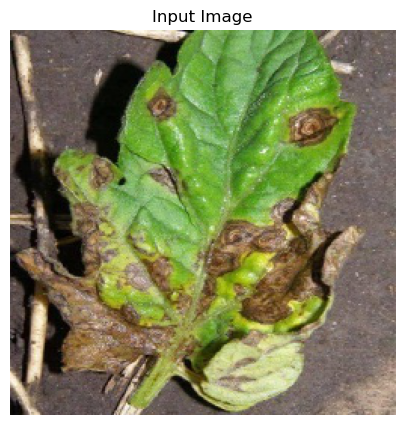

In [29]:
image_index = 10  #lets try to visualize the image after loading 
input_image=test_images[image_index]
plt.figure(figsize=(10, 5))
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')
plt.show()

<font size="5"><font color="DarkPurple">Lets perform required transformation of images to make sure we normalize and also maintain uniformity in data being passed to the model<font size="5"><font color="DarkPurple">

In [30]:
data_transforms = transforms.Compose([
    Lambda(lambda x: Image.fromarray((x).astype(np.uint8))),
    transforms.ToTensor()])
X_test=torch.stack([data_transforms(image) for image in test_images])
test_data=TensorDataset(X_test)
test_loader=DataLoader(test_data, batch_size=params['batch_size'])

In [31]:
images=next(iter(test_loader))
# Print the size, shape, and datatype of the images
print("Size:",images[0].size())
print("Shape:",images[0].shape)
print("Datatype:",images[0].dtype)

Size: torch.Size([60, 3, 256, 256])
Shape: torch.Size([60, 3, 256, 256])
Datatype: torch.float32


<font size="5"><font color="DarkPurple">Load the saved classification model with its respective weights<font size="5"><font color="DarkPurple">

In [21]:
classification_model=create_efficientnet_model()
classification_model.load_state_dict(torch.load('best_model12.pth'))
classification_model.to(device)

Loaded pretrained weights for efficientnet-b2


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

<font size="5"><font color="DarkPurple">We can now export the predictions to csv by saving by reading it as pandas dataframe and then exporting the same as csv<font size="5"><font color="DarkPurple">

In [33]:
classification_model.eval()
test_preds=[]
with torch.no_grad():
    for inputs in test_loader:
        inputs=inputs[0].to(device)  # Index into inputs to get the tensor
        outputs=classification_model(inputs)
        test_preds.extend(outputs.detach().cpu().numpy())
binary_preds=[1 if pred>=0.5 else 0 for pred in test_preds]
df=pd.DataFrame({'id':image_names,'binary_pred':binary_preds})
print(df.head())

             id  binary_pred
0  Img_1000.png            1
1  Img_1001.png            0
2  Img_1002.png            1
3  Img_1003.png            0
4  Img_1004.png            0


In [34]:
df.to_csv('predictions8.csv', index=False)

<font size="5"><font color="DarkPurple">To start with our segmentation task lets start by visualizing the masks from which we see that the image value is binary and its either 0 or 1<font size="5"><font color="DarkPurple">

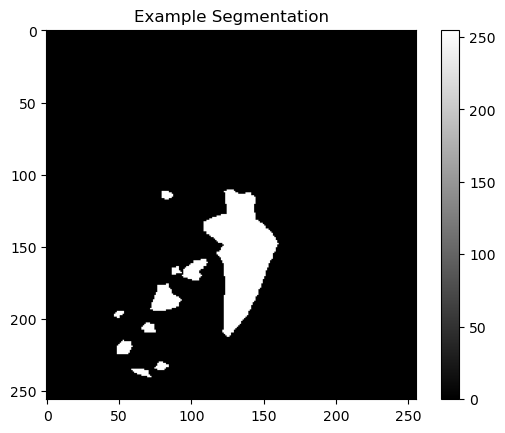

In [35]:
plt.imshow(train_segmentations[0],cmap='gray')
plt.title('Example Segmentation')
plt.colorbar()
plt.show()

In [36]:
print("train_images:",np.shape(Ntrain_img))
print("train_segmentations:",np.shape(Ntrain_seg))
len(np.unique(train_labels))

train_images: (919, 256, 256, 3)
train_segmentations: (919, 256, 256, 1)


2

<font size="5"><font color="DarkPurple">To start with our segmentation model ,Lets start by loading the normalized images and segmentation maps we had. <font size="5"><font color="DarkPurple">

In [22]:
num_healthy_images=20
healthy_indices=np.where(train_labels=='Healthy')[0][:num_healthy_images]
diseased_indices=np.where(train_labels=='diseased')[0]
selected_indices=np.concatenate([healthy_indices,diseased_indices])
selected_images=Ntrain_img[selected_indices]
selected_segmentations=Ntrain_seg[selected_indices]
print(f"Total number of images: {len(selected_images)}, Number of healthy images: {len(healthy_indices)}, Number of diseased images: {len(diseased_indices)}, Total number of segmentations: {len(selected_segmentations)}, Number of healthy segmentations: {len(healthy_indices)}, Number of diseased segmentations: {len(diseased_indices)}")
print(f"Shape of one image: {selected_images[0].shape}, Shape of one segmentation: {selected_segmentations[0].shape}")

Total number of images: 443, Number of healthy images: 20, Number of diseased images: 423, Total number of segmentations: 443, Number of healthy segmentations: 20, Number of diseased segmentations: 423
Shape of one image: (256, 256, 3), Shape of one segmentation: (256, 256, 1)


<font size="5"><font color="DarkPurple">We observed that there was class imbalance.
--So in my first runs while i trained on whole dataset and as I was using binary cross entropy loss and dice error the model would show good accuracy but would classify all image being healthy.<BR>
--This is the result of having segmented areas which are smaller areas compared to the whole image and also especially when we have more healthy images.<font size="5"><font color="DarkPurple">

In [23]:
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

<font size="5"><font color="DarkPurple">--So we start with a Unet model as discussed in class which has encoder decoder<BR>
--Use torch.summary to check the dimension of input and output of each layer to design the model<font size="5"><font color="DarkPurple">

In [24]:
import torch
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),   # Output shape: (64,256,256) 
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),  # Output shape: (64,256,256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2))      # Output shape: (64,128,128)
        self.decoder=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),  # Output shape: (64,128,128)
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),  # Output shape: (64,128,128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64,1,kernel_size=2,stride=2))  # Output shape: (1,256,256)    
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return torch.sigmoid(x)

<font size="5"><font color="DarkPurple">--I observed that the model was performing poorly as it was loosing out on the contextual information,to avoid this we can add skip connections (which connects the encoder and decoder in the same level and concatenates the the image) which provides a better contextual information in the model.<BR>
--We will also make use of pretrained VGG16 as the backbone for our model to extract some feature information from the images.<font size="5"><font color="DarkPurple">

In [25]:
from torchsummary import summary
segmentation_model = UNet().cuda()
summary(segmentation_model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          36,928
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              ReLU-9         [-1, 64, 128, 128]               0
  ConvTranspose2d-10          [-1, 1, 256, 256]             257
Total params: 112,833
Trainable params: 112,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 168.50
Params size (MB): 0.43
Estimated

<font size="5"><font color="DarkPurple">Lets implement data augmentation to make the model more generalised to our training data.  <font size="5"><font color="DarkPurple">

In [83]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
class SegmentationDataset(Dataset):
    def __init__(self, images, segmentations, transform=None):
        self.images = images
        self.segmentations = segmentations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        segmentation = self.segmentations[idx]        
        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)        
        return image, segmentation
transform = transforms.Compose([transforms.ToTensor()])
dataset = SegmentationDataset(selected_images, selected_segmentations, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [90]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
class SegmentationDataset(Dataset):
    def __init__(self, images, segmentations, transform=None):
        self.images = images
        self.segmentations = segmentations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        segmentation = self.segmentations[idx]        
        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)        
        return image, segmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  # Output size (height and width) of crop
    transforms.ToTensor()
])
dataset = SegmentationDataset(selected_images, selected_segmentations, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [96]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
class SegmentationDataset(Dataset):
    def __init__(self, images, segmentations, transform=None):
        self.images = images
        self.segmentations = segmentations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        segmentation = self.segmentations[idx]        
        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)        
        return image, segmentation

transform = transforms.Compose([
    transforms.ToTensor()  
])
dataset = SegmentationDataset(selected_images, selected_segmentations, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [91]:
augmented_images = []
augmented_segmentations = []
for i in range(len(selected_images)):
    # Original image and segmentation
    augmented_images.append(selected_images[i])
    augmented_segmentations.append(selected_segmentations[i])
    # Augmented images and segmentations
    for _ in range(4):  # for creating 9 augmented versions
        image = transform(selected_images[i])
        segmentation = transform(selected_segmentations[i])
        augmented_images.append(image.permute(1, 2, 0).numpy())  # convert tensor back to numpy array and rearrange dimensions
        augmented_segmentations.append(segmentation.permute(1, 2, 0).numpy())  # convert tensor back to numpy array and rearrange dimensions

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_segmentations = np.array(augmented_segmentations)

# Now you can use `augmented_images` and `augmented_segmentations` in your `SegmentationDataset`
dataset = SegmentationDataset(augmented_images, augmented_segmentations, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


In [97]:
segmentation_model=UNet()
criterion=nn.BCELoss()
optimizer=optim.Adam(segmentation_model.parameters(),lr=0.001)
num_epochs=10
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
segmentation_model.to(device)
num_epochs=10
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
segmentation_model.to(device)
for epoch in range(num_epochs):
    running_bce_loss=0.0
    running_dice_loss=0.0    
    for images,segmentations in dataloader:
        images,segmentations=images.to(device),segmentations.to(device)
        optimizer.zero_grad()
        outputs=segmentation_model(images)
        bce_loss=criterion(outputs,segmentations)
        smooth=1e-6
        intersection=torch.sum(outputs*segmentations)
        union=torch.sum(outputs)+torch.sum(segmentations)
        dice_loss=1-(2.0*intersection+smooth)/(union+smooth)
        loss=bce_loss+dice_loss
        loss.backward()
        optimizer.step()
        running_bce_loss+=bce_loss.item()
        running_dice_loss+=dice_loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, BCE Loss: {running_bce_loss/len(dataloader)}, Dice Loss: {running_dice_loss/len(dataloader)}")
print('Finished Training')

Epoch 1/10, BCE Loss: 0.3656785100698471, Dice Loss: 0.56726453171836
Epoch 2/10, BCE Loss: 0.3059589578045739, Dice Loss: 0.45512839953104656
Epoch 3/10, BCE Loss: 0.28761663734912873, Dice Loss: 0.4238659421602885
Epoch 4/10, BCE Loss: 0.27538709292809166, Dice Loss: 0.39892714685863917
Epoch 5/10, BCE Loss: 0.2747703767485089, Dice Loss: 0.40924041271209716
Epoch 6/10, BCE Loss: 0.268862196471956, Dice Loss: 0.3925570050875346
Epoch 7/10, BCE Loss: 0.26118889848391214, Dice Loss: 0.3785766628053453
Epoch 8/10, BCE Loss: 0.2568979150719113, Dice Loss: 0.37766122155719334
Epoch 9/10, BCE Loss: 0.25326725757784313, Dice Loss: 0.37244666549894545
Epoch 10/10, BCE Loss: 0.2705538938442866, Dice Loss: 0.3781941612561544
Finished Training


In [92]:
torch.save(segmentation_model.state_dict(),'unet_model4.pth')

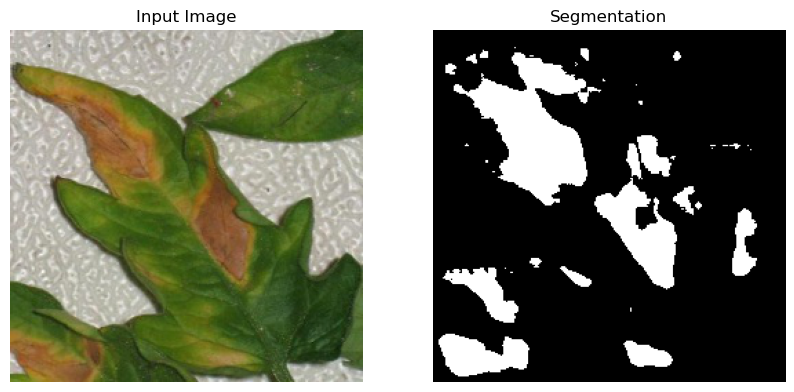

In [98]:
threshold=0.5
image_index = diseased_indices[110]
input_image = selected_images[image_index]
input_image_tensor = transform(input_image).unsqueeze(0).to(device)
segmentation_model.eval()
with torch.no_grad():
    output_segmentation = segmentation_model(input_image_tensor)
    output_segmentation = (output_segmentation > threshold).float()  # Apply threshold here
output_segmentation = output_segmentation.squeeze(0).cpu().numpy()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_segmentation[0], cmap='gray')  # Squeeze the segmentation tensor
plt.title('Segmentation')
plt.axis('off')
plt.show()


<font size="5"><font color="DarkPurple">Lets add skip networks as taught in class to get more contextuiality because after perofdming training  the model could not differentiate between the backgrounf and foreground sometimes. Especially when there are similar color or textured background eklemenrts like hands and soil<font size="5"><font color="DarkPurple">

In [73]:
"""class DiceLoss(nn.Module):
    def forward(self, input, target):
        intersection = (input * target).sum()
        return 1 - (2. * intersection) / (input.sum() + target.sum())"""  
#model faced division by zero error so modified dice loss formula avoiding numerator reaching zero
class DiceLoss(nn.Module):
    def forward(self, input, target):
        smooth = 1e-6
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat*tflat).sum()        
        return 1 - ((2.*intersection+smooth)/(iflat.sum()+tflat.sum()+smooth))

In [74]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        vgg16 = models.vgg16(pretrained=True)
        for param in vgg16.parameters():
            param.requires_grad = False

        self.encoder1 = vgg16.features[0:4]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = vgg16.features[5:9]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = vgg16.features[10:14]
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True))
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1))
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        mid = self.middle(self.pool3(enc3))
        dec3 = self.decoder3(torch.cat([self.up3(mid), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.up1(dec2), enc1], dim=1))
        return torch.sigmoid(dec1)

In [100]:
class SegmentationDataset(Dataset):
    def __init__(self, images, segmentations, transform=None):
        self.images = images
        self.segmentations = segmentations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        segmentation = self.segmentations[idx]        
        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)        
        return image, segmentation

transform = transforms.Compose([
    transforms.ToTensor()  
])
dataset = SegmentationDataset(selected_images, selected_segmentations, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [75]:
segmentation_model = UNet()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
dice_loss = DiceLoss()
optimizer = optim.Adam(segmentation_model.parameters(), lr=0.001, weight_decay=0.01)
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segmentation_model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    running_dice_loss = 0.0
    total = 0
    correct = 0
    for images, segmentations in dataloader:
        images, segmentations = images.to(device), segmentations.to(device)        
        optimizer.zero_grad()
        outputs = segmentation_model(images)        
        loss = criterion(outputs, segmentations)
        d_loss = dice_loss(outputs, segmentations)
        loss.backward()        
        optimizer.step()        
        running_loss += loss.item()
        running_dice_loss += d_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += segmentations.size(0)
        correct += (predicted == segmentations).sum().item()
    print(f"Epoch {epoch+1}/{num_epochs}, BCE Loss: {running_loss/len(dataloader)}, Dice Loss: {running_dice_loss/len(dataloader)}, Accuracy: {100 * correct / total}%")

print('Finished Training')


C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, BCE Loss: 0.2922181339585485, Dice Loss: 0.5800109605218702, Accuracy: 54951200.90293454%
Epoch 2/10, BCE Loss: 0.27539661979096736, Dice Loss: 0.539918293533153, Accuracy: 54951200.90293454%
Epoch 3/10, BCE Loss: 0.2783000016454649, Dice Loss: 0.5510626263058751, Accuracy: 54951200.90293454%
Epoch 4/10, BCE Loss: 0.26035456419932923, Dice Loss: 0.5130294993284324, Accuracy: 54951200.90293454%
Epoch 5/10, BCE Loss: 0.2617621474792134, Dice Loss: 0.5156471078067547, Accuracy: 54951200.90293454%
Epoch 6/10, BCE Loss: 0.25700168977607185, Dice Loss: 0.5066991181997897, Accuracy: 54951200.90293454%
Epoch 7/10, BCE Loss: 0.25239945171110784, Dice Loss: 0.4985696084074188, Accuracy: 54951200.90293454%
Epoch 8/10, BCE Loss: 0.2509410638639674, Dice Loss: 0.4934951249955739, Accuracy: 54951200.90293454%
Epoch 9/10, BCE Loss: 0.25205723460318, Dice Loss: 0.4973016774143107, Accuracy: 54951200.90293454%
Epoch 10/10, BCE Loss: 0.2519450434914561, Dice Loss: 0.49367256896490436, Accura

In [80]:
import gc
del images, segmentations, outputs  # Delete unnecessary tensors
torch.cuda.empty_cache()  # Free up GPU memory
gc.collect()  # Invoke garbage collector

34933

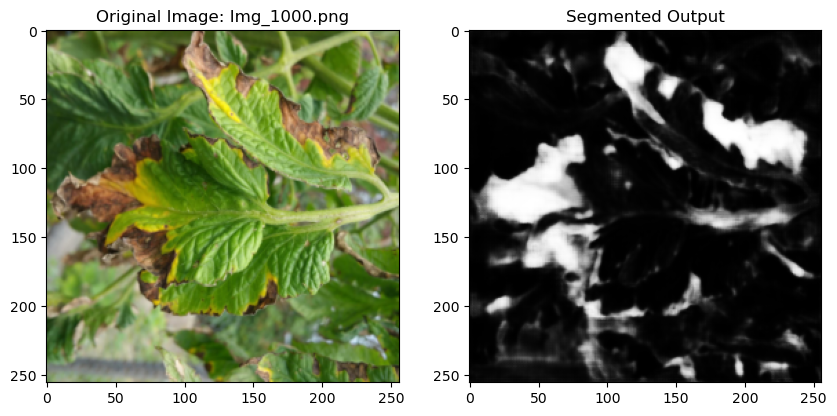

In [99]:
test_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'
test_images = []
image_names = []

# Load test images and their names
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    concat_img = Image.open(img_path)
    concat_img = np.array(concat_img)
    img = concat_img[:, :256, :3]  # Select only the first 3 channels
    test_images.append(img)
    image_names.append(img_file)

# Convert test_images to a numpy array and transpose the dimensions
test_images = np.array(test_images)
test_images = np.transpose(test_images, (0, 3, 1, 2))

# Normalize the test images
Ntest_img = normalize_images(test_images)

# Convert to tensor
test_images_tensor = torch.from_numpy(Ntest_img).float().to(device)

# Define a function to divide data into batches
def divide_into_batches(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Divide test_images_tensor into batches
test_images_batches = divide_into_batches(test_images_tensor, batch_size=10)

# Perform segmentation on test images in batches
outputs = []
for batch in test_images_batches:
    segmentation_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        batch_output = segmentation_model(batch)
    outputs.append(batch_output)

# Concatenate the outputs from all batches
outputs = torch.cat(outputs)

# Convert the outputs to numpy array
outputs_np = outputs.cpu().numpy()


# Display an image and its segmented output
idx = 0  # Index of the image you want to display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(test_images[idx], (1, 2, 0)))
plt.title(f'Original Image: {image_names[idx]}')
plt.subplot(1, 2, 2)
plt.imshow(outputs_np[idx, 0, :, :], cmap='gray')
plt.title('Segmented Output')
plt.show()


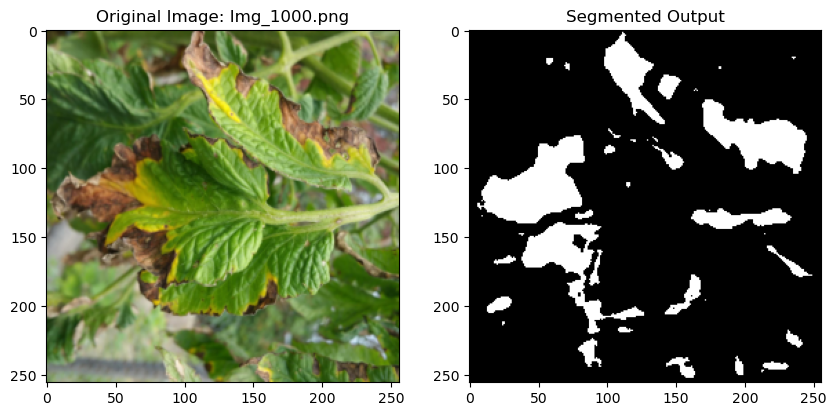

Input image shape: (3, 256, 256)
Output image shape: (1, 256, 256)


In [100]:
import matplotlib.pyplot as plt

# Directory containing your test images
test_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'

# Initialize test_images as an empty list
test_images = []
image_names = []

# Load test images and their names
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    concat_img = Image.open(img_path)
    concat_img = np.array(concat_img)
    img = concat_img[:, :256, :3]  # Select only the first 3 channels
    test_images.append(img)
    image_names.append(img_file)

# Convert test_images to a numpy array and transpose the dimensions
test_images = np.array(test_images)
test_images = np.transpose(test_images, (0, 3, 1, 2))

# Normalize the test images
Ntest_img = normalize_images(test_images)

# Convert to tensor
test_images_tensor = torch.from_numpy(Ntest_img).float().to(device)

# Perform segmentation on test images in batches
outputs = []
for batch in test_images_batches:
    segmentation_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        batch_output = segmentation_model(batch)
        # Apply threshold
        batch_output = (batch_output > 0.4).float()
    outputs.append(batch_output)

# Concatenate the outputs from all batches
outputs = torch.cat(outputs)

# Convert the outputs to numpy array
outputs_np = outputs.cpu().numpy()

# Display an image and its segmented output
idx = 0  # Index of the image you want to display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(test_images[idx], (1, 2, 0)))
plt.title(f'Original Image: {image_names[idx]}')
plt.subplot(1, 2, 2)
plt.imshow(outputs_np[idx, 0, :, :], cmap='gray')
plt.title('Segmented Output')
plt.show()

# Print the shape of the input and output images
print(f"Input image shape: {test_images[idx].shape}")
print(f"Output image shape: {outputs_np[idx].shape}")


In [44]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

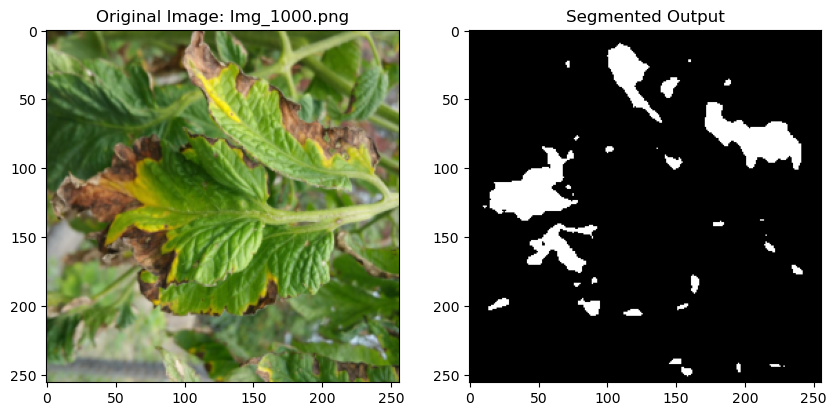

Input image shape: (3, 256, 256)
Output image shape: (1, 256, 256)


In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Directory containing your test images
test_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'

# Initialize test_images as an empty list
test_images = []
image_names = []

# Load test images and their names
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    concat_img = Image.open(img_path)
    concat_img = np.array(concat_img)
    img = concat_img[:, :256, :3]  # Select only the first 3 channels
    test_images.append(img)
    image_names.append(img_file)

# Convert test_images to a numpy array and transpose the dimensions
test_images = np.array(test_images)
test_images = np.transpose(test_images, (0, 3, 1, 2))

# Normalize the test images
Ntest_img = normalize_images(test_images)

# Convert to tensor
test_images_tensor = torch.from_numpy(Ntest_img).float().to(device)

# Perform segmentation on test images in batches
outputs = []
for batch in test_images_batches:
    segmentation_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        batch_output = segmentation_model(batch)
        # Apply threshold
        batch_output = (batch_output > 0.4).float()
    outputs.append(batch_output)

# Concatenate the outputs from all batches
outputs = torch.cat(outputs)

# Convert the outputs to numpy array
outputs_np = outputs.cpu().numpy()

# Display an image and its segmented output
idx = 0  # Index of the image you want to display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(test_images[idx], (1, 2, 0)))
plt.title(f'Original Image: {image_names[idx]}')
plt.subplot(1, 2, 2)
plt.imshow(outputs_np[idx, 0, :, :], cmap='gray')
plt.title('Segmented Output')
plt.show()

# Print the shape of the input and output images
print(f"Input image shape: {test_images[idx].shape}")
print(f"Output image shape: {outputs_np[idx].shape}")

# Define the RLE conversion function
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Initialize a list to store the RLE results
rle_results = []

# Convert the binary masks to RLE and store the results
for output in outputs_np:
    # Reshape the output to (256, 256, 3)
    output_reshaped = np.repeat(output, 3, axis=0).reshape((256, 256, 3))
    # Convert the output to RLE
    rle = mask2rle(output_reshaped)
    rle_results.append(rle)

# Create a DataFrame with the image names and RLE results
df = pd.DataFrame({
    'id': image_names,
    'segmentation_pred': rle_results
})

# Replace empty RLE results with 'Healthy'
df['segmentation_pred'] = df['segmentation_pred'].apply(lambda x: 'Healthy' if x == '' else x)

# Save the DataFrame to a CSV file
df.to_csv('segmentation_results.csv', index=False)


In [163]:
import os
import numpy as np
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader

# Define a function to load segmentation test images and perform preprocessing
def load_segmentation_test(test_dir):
    test_images = []
    image_names = []

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        concat_img = Image.open(img_path)
        concat_img = np.array(concat_img)
        img = concat_img[:, :256, :3]  # Select only the first 3 channels
        test_images.append(img)
        image_names.append(img_file)

    test_images = np.array(test_images)
    test_images = np.transpose(test_images, (0, 3, 1, 2))

    # Normalize the test images (you need to define this function)
    normalized_test_images = normalize_images(test_images)

    return normalized_test_images, image_names

# Define a function to perform segmentation evaluation using the model
def perform_segmentation_evaluation(segmentation_model, test_images, device):
    outputs = []
    for batch in test_images_batches:
        segmentation_model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            batch_output = segmentation_model(batch)
            # Apply threshold
            batch_output = (batch_output > 0.4).float()
        outputs.append(batch_output)

    # Concatenate the outputs from all batches
    outputs = torch.cat(outputs)

    # Convert the outputs to numpy array
    outputs_np = outputs.cpu().numpy()

    # Initialize a list to store the RLE results
    rle_results = []

    # Convert the binary masks to RLE and store the results
    for output in outputs_np:
        # Reshape the output to (256, 256, 3)
        output_reshaped = np.repeat(output, 3, axis=0).reshape((256, 256, 3))
        # Convert the output to RLE
        rle = mask2rle(output_reshaped)
        rle_results.append(rle)

    return rle_results

# Define a function to convert binary masks to RLE format
def mask2rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Directory containing your test images
test_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'

# Load and preprocess segmentation test images
test_images, image_names = load_segmentation_test(test_dir)

# Convert to tensor
test_images_tensor = torch.from_numpy(test_images).float().to(device)

# Define DataLoader for test data
batch_size = 16
test_data = torch.utils.data.TensorDataset(test_images_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Perform segmentation evaluation using the model
segmentation_results = perform_segmentation_evaluation(segmentation_model, test_images, device)

# Create a DataFrame with the image names and segmentation results
df = pd.DataFrame({
    'id': image_names,
    'segmentation_pred': segmentation_results
})
df['segmentation_pred'] = df['segmentation_pred'].apply(lambda x: 'Healthy' if x == '' else x)
# Save the DataFrame to a CSV file
df.to_csv('segmentation_resultsnew.csv', index=False)


In [79]:
import matplotlib.pyplot as plt

# Choose an image from the diseased class
image_index = diseased_indices[150]
input_image = selected_images[image_index]

# Convert input image to tensor and add batch dimension
input_image_tensor = transform(input_image).unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Perform segmentation
with torch.no_grad():
    output_segmentation = model(input_image_tensor)

# Remove batch dimension and convert segmentation tensor to numpy array
output_segmentation = output_segmentation.squeeze(0).cpu().numpy()

# Plot the input image and segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_segmentation[0], cmap='gray')  # Squeeze the segmentation tensor
plt.title('Segmentation')
plt.axis('off')

plt.show()


NameError: name 'model' is not defined

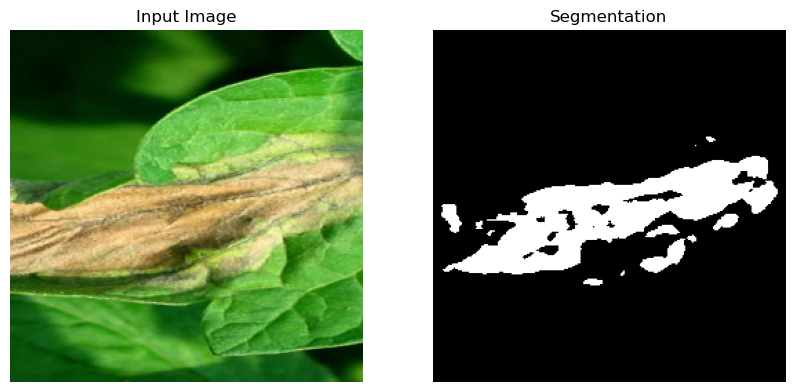

In [38]:
import matplotlib.pyplot as plt
threshold = 0.5
# Choose an image from the diseased class
image_index = diseased_indices[150]
input_image = selected_images[image_index]

# Convert input image to tensor and add batch dimension
input_image_tensor = transform(input_image).unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Perform segmentation
with torch.no_grad():
    output_segmentation = model(input_image_tensor)
    output_segmentation = (output_segmentation > threshold).float()  # Apply threshold here

# Remove batch dimension and convert segmentation tensor to numpy array
output_segmentation = output_segmentation.squeeze(0).cpu().numpy()

# Plot the input image and segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_segmentation[0], cmap='gray')  # Squeeze the segmentation tensor
plt.title('Segmentation')
plt.axis('off')

plt.show()


In [328]:
import os
from PIL import Image

# Create a directory to save the segmented images
segmented_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/output_segmentation1'
os.makedirs(segmented_dir, exist_ok=True)

# Set the model to evaluation mode
model.eval()

# Loop over all images
for i, (input_image, image_name) in enumerate(zip(selected_images, image_names)):
    # Convert input image to tensor and add batch dimension
    input_image_tensor = transform(input_image).unsqueeze(0).to(device)

    # Perform segmentation
    with torch.no_grad():
        output_segmentation = model(input_image_tensor)
        output_segmentation = (output_segmentation > threshold).float()  # Apply threshold here

    # Remove batch dimension and convert segmentation tensor to numpy array
    output_segmentation = output_segmentation.squeeze(0).cpu().numpy()

    # Convert the segmentation to an image
    segmentation_image = Image.fromarray((output_segmentation[0] * 255).astype(np.uint8))  # Squeeze the segmentation tensor

    # Save the segmentation image with the original image name
    segmentation_image.save(os.path.join(segmented_dir, f'{os.path.splitext(image_name)[0]}_segmentation.png'))

print(f"Segmented images saved in {segmented_dir}")

Segmented images saved in E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/output_segmentation1


In [182]:
import os
import numpy as np
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader

# Define a function to load segmentation test images and perform preprocessing
def load_segmentation_test(test_dir):
    test_images = []
    image_names = []

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        concat_img = Image.open(img_path)
        concat_img = np.array(concat_img)
        img = concat_img[:, :256, :3]  # Select only the first 3 channels
        test_images.append(img)
        image_names.append(img_file)

    test_images = np.array(test_images)
    test_images = np.transpose(test_images, (0, 3, 1, 2))

    # Normalize the test images (you need to define this function)
    normalized_test_images = normalize_images(test_images)

    return normalized_test_images, image_names

# Define a function to perform segmentation evaluation using the model
def perform_segmentation_evaluation(segmentation_model, test_images, device):
    outputs = []
    for batch in test_images_batches:
        print("Original batch shape:", batch.shape)
        segmentation_model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            batch_output = segmentation_model(batch)
            # Apply threshold
            batch_output = (batch_output > 0.4).float()
        outputs.append(batch_output)

    # Concatenate the outputs from all batches
    outputs = torch.cat(outputs)
    print("Concatenated outputs shape:", outputs.shape)

    # Convert the outputs to numpy array
    outputs_np = outputs.cpu().numpy()

    # Initialize a list to store the RLE results
    rle_results = []

    # Convert the binary masks to RLE and store the results
    for output in outputs_np:
        # Reshape the output to (256, 256, 3)
        output_reshaped = np.repeat(output, 3, axis=0).reshape((256, 256, 3))
        print("Reshaped output shape:", output_reshaped.shape)
        # Convert the output to RLE
        rle = mask2rle(output_reshaped)
        rle_results.append(rle)

    return rle_results

# Define a function to convert binary masks to RLE format
def mask2rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Directory containing your test images
test_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'

# Load and preprocess segmentation test images
test_images, image_names = load_segmentation_test(test_dir)

# Load test images and apply transformations
test_images_classification, _ = load_test_images(test_dir)  # Assuming you have a function to load test images

# Convert to tensor and apply transformations
test_images_tensor_classification = apply_transforms_to_test_images(test_images_classification)

# Define DataLoader for test data for classification
batch_size_classification = 16
test_data_classification = torch.utils.data.TensorDataset(test_images_tensor_classification)
test_loader_classification = DataLoader(test_data_classification, batch_size=batch_size_classification)

# Perform classification evaluation using the model
classification_results = []
with torch.no_grad():
    for inputs in test_loader_classification:
        inputs = inputs[0].to(device)  # Index into inputs to get the tensor
        outputs = classification_model(inputs)
        classification_results.extend(outputs.detach().cpu().numpy())

# Post-processing predictions for classification
binary_preds = [1 if pred >= 0.5 else 0 for pred in classification_results]

# Perform segmentation evaluation using the model
segmentation_results = perform_segmentation_evaluation(segmentation_model, test_images, device)

# Combine classification and segmentation results
df = pd.DataFrame({
    'id': image_names,
    'binary_pred': binary_preds,
    'segmentation_pred': segmentation_results
})

# Save the DataFrame to a CSV file
df.to_csv('combined_results6.csv', index=False)


Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original batch shape: torch.Size([10, 3, 256, 256])
Original bat

In [192]:
import os
import numpy as np
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader

# Define a function to load segmentation test images and perform preprocessing
def load_segmentation_test(test_dir):
    test_images = []
    image_names = []

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        concat_img = Image.open(img_path)
        concat_img = np.array(concat_img)
        img = concat_img[:, :256, :3]  # Select only the first 3 channels
        test_images.append(img)
        image_names.append(img_file)

    test_images = np.array(test_images)
    test_images = np.transpose(test_images, (0, 3, 1, 2))

    # Normalize the test images (you need to define this function)
    normalized_test_images = normalize_images(test_images)

    return normalized_test_images, image_names

# Define a function to perform segmentation evaluation using the model
def perform_segmentation_evaluation(segmentation_model, test_images, device):
    outputs = []
    for batch in test_images_batches:
        segmentation_model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            batch_output = segmentation_model(batch)
            # Apply threshold
            batch_output = (batch_output > 0.4).float()
            if (batch_output < 0).any() or (batch_output > 1).any():
                print("Warning: Output contains values outside the range of 0 and 1.")
        outputs.append(batch_output)

    # Concatenate the outputs from all batches
    outputs = torch.cat(outputs)

    # Convert the outputs to numpy array
    outputs_np = outputs.cpu().numpy()

    # Initialize a list to store the RLE results
    rle_results = []

    # Convert the binary masks to RLE and store the results
    for output in outputs_np:
        # Reshape the output to (256, 256, 3)
        output_reshaped = np.repeat(output, 3, axis=0).reshape((256, 256, 3))
        # Convert the output to RLE
        rle = mask2rle(output_reshaped)
        rle_results.append(rle)

    return rle_results

# Define a function to convert binary masks to RLE format
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# Directory containing your test images
test_dir = 'E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/ASSN2_Q2/test'

# Load and preprocess segmentation test images
test_images, image_names = load_segmentation_test(test_dir)

# Load test images and apply transformations
test_images_classification, _ = load_test_images(test_dir)  # Assuming you have a function to load test images

# Convert to tensor and apply transformations
test_images_tensor_classification = apply_transforms_to_test_images(test_images_classification)

# Define DataLoader for test data for classification
batch_size_classification = 16
test_data_classification = torch.utils.data.TensorDataset(test_images_tensor_classification)
test_loader_classification = DataLoader(test_data_classification, batch_size=batch_size_classification)

# Perform classification evaluation using the model
classification_results = []
with torch.no_grad():
    for inputs in test_loader_classification:
        inputs = inputs[0].to(device)  # Index into inputs to get the tensor
        outputs = classification_model(inputs)
        classification_results.extend(outputs.detach().cpu().numpy())

# Post-processing predictions for classification
binary_preds = [1 if pred >= 0.5 else 0 for pred in classification_results]

# Perform segmentation evaluation using the model
segmentation_results = perform_segmentation_evaluation(segmentation_model, test_images, device)

# Combine classification and segmentation results
df_existing = pd.read_csv('E:/IISC academics/SEM- 2/DS-216 Machine learning for data science/Assignments/Assignment 2/sample_submission.csv')  # Read the existing CSV file
df_existing['binary_pred'] = binary_preds  # Update binary_pred column
df_existing['segmentation_pred'] = segmentation_results  # Update segmentation_pred column
df_existing['segmentation_pred'] = np.where(df_existing['binary_pred'] == 1, df_existing['segmentation_pred'], 'Healthy')
df_existing['segmentation_pred'] = df_existing['segmentation_pred'].fillna('Healthy')

# Save the modified DataFrame back to the CSV file
df_existing.to_csv('combined_results_sample.csv', index=False)
